# Базовый пример выполнения задания хакатона

**Задача — автоматически находить на спутниковых снимках следующие объекты:**

| Класс | Описание |
|-------|----------|
| Отвалы | Насыпи из пустой породы |
| Карьерные ямы | Котлованы добычи |
| Хвостохранилища | Отходы обогащения |


## Подключение необходимых модулей

In [ ]:
!pip install numpy  # Работа с массивами
!pip install rasterio  # Работа с геоданными
!pip install matplotlib  # Работа с инфографиками
!pip install torch  # Фреймворк машинного обучения
!pip install segmentation-models-pytorch  # Базовые модели для семантической сегментации

!pip install tqdm  # Прогресс бар

# Если google colab
from google.colab import drive # импорт и подключение к гугл диску
drive.mount('/content/drive')

!apt-get install p7zip-full
# распаковка набора данных
!7z x /content/drive/MyDrive/ScienceDataLab/train.zip -o/content
!7z x /content/drive/MyDrive/ScienceDataLab/test.zip -o/content

## Создание класса датасета
Функции датасета:
- Подгружает данные во время обучения
- Экономит оперативную память

In [ ]:
import os
import functools
import glob
import json
from tqdm import tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.v2 as transforms
import segmentation_models_pytorch as smp
import sklearn
from sklearn.ensemble import RandomForestClassifier

# Custom augmentations
def get_train_transform(_NUM_CHANNELS):
    means = []
    stds = []
    for i in range(_NUM_CHANNELS):
        means.append(-1.0)
        stds.append(2.0)
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ElasticTransform(alpha=20.0, sigma=5.0),
        transforms.Normalize(means, stds)
    ])

def get_val_transform(_NUM_CHANNELS):
    means = []
    stds = []
    for i in range(_NUM_CHANNELS):
        means.append(0.0)
        stds.append(1.0)
    return transforms.Compose([
        transforms.Normalize(means, stds)
    ])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, classes=1, channels=None, return_paths=False, transform=None):
        self.return_paths = return_paths
        if not self.return_paths:
            assert len(imgs) == len(masks), "imgs != masks"
        self.transform = transform
        self.channels = channels
        self.classes = classes
        self.imgs = imgs
        self.masks = masks

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, pos):
        pth_tif = self.imgs[pos]
        with rasterio.open(pth_tif) as f:
            img = f.read()

        # print(img.shape)
        # # Вычисление вегетационного индекса NDVI
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     NDVI = np.where(img[3] + img[2] == 0, 0., -(img[3] - img[2]) / (img[3] + img[2]))
        # print(NDVI.shape)
        # NDVI = NDVI[np.newaxis]
        # print(NDVI.shape)
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, NDVI, axis=0)
        # print(img.shape)
        # # Вычисление вегетационного индекса MNDWI + большой засвет, мб делить на 2 (++ вода и хвосты)
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     MNDWI = np.where(img[1] + img[4] == 0, 0., (img[1] - img[4])/(img[1] + img[4]))
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, MNDWI[np.newaxis], axis=0)

        # # Вычисление вегетационного индекса FE (Fe3+) ++ засвечивает раскопки, подавляет растительность +-
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     IO = np.where(img[2] * img[1] == 0, 0., img[2] / img[1])
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, IO[np.newaxis], axis=0)

        # # Вычисление вегетационного индекса BSI ((B11 + B04) - (B08 + B02)) / ((B11 + B04) + (B08 + B02))
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     BSI = np.where((img[4] + img[2]) + (img[3] + img[0]) == 0, 0., (((img[4] + img[2]) - (img[3] + img[0])) / ((img[4] + img[2]) + (img[3] + img[0]))))
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, BSI[np.newaxis], axis=0)

        # # Вычисление вегетационного индекса NDWI
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     NDWI = np.where(img[1] + img[3] == 0, 0., (img[1] - img[3]) / (img[1] + img[3]))
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, NDWI[np.newaxis], axis=0)

        # # Вычисление вегетационного индекса SC (Soil Composition) + хорошо засвечивает раскопки
        # with np.errstate(divide='ignore',invalid='ignore'):
        #     SC = np.where(img[4] + img[3] == 0, 0., (img[4] - img[3])/(img[4] + img[3]))
        # # Добавление нового признака последним каналом изображения
        # img = np.append(img, SC[np.newaxis], axis=0)

        if self.channels: img = img[np.array(self.channels)]

        if not self.return_paths:
            pth_mask = self.masks[pos]
            with rasterio.open(pth_mask) as f:
                mask = f.read()
            mask = torch.from_numpy(mask[0].astype(np.int64))   # Преобразование масок и снимков в формат данных для обучение

            mask = F.one_hot(mask, num_classes=self.classes)

            mask = mask.detach().numpy()
            mask = torch.from_numpy(mask.astype(np.int64)).moveaxis(2, 0)
            assert mask.shape[0] == (self.classes)
            mask = torchvision.tv_tensors.Mask(mask)
        # Место для генерации признаков



        img = img.transpose(1, 2, 0) # Bands, Height, Width -> H, W, B
        img = torch.from_numpy(img.astype(np.float32)).moveaxis(2, 0)

        if self.transform and not self.return_paths:
            img, mask = self.transform(img, mask)
        if self.transform and self.return_paths:
            img = self.transform(img)

        return (img, pth_tif) if self.return_paths else (img, mask)

## Подготовка датасетов для обучения

**Используемые каналы спутниковых снимков:**  
- B02: Синий (10 м),
- B03: Зеленый (10 м),
- B04: Красный (10 м),
- B05: Красный край (20 м),
- B06: Красный край (20 м),
- B07: Красный край (20 м).

### Создание переменных

In [ ]:
# Указать путь до папки с датасетом
DIR_DATASET = "train"  # путь к набору данных
DIR_OPENSET = "test"
NUM_CLASSES = 4  # 4 класса: background (фон), wrd (отвалы), pit (открытые карьеры), tsf (хвостохранилища)

LST_TRAIN_IMG = glob.glob(DIR_DATASET + "/train/image/*.tif")  # Список обучающих изображений
LST_TRAIN_MASK = glob.glob(DIR_DATASET + "/train/mask/*.tif")  # Список обучающих масок
LST_VAL_IMG = glob.glob(DIR_DATASET + "/val/image/*.tif")  # Список валидационных изображений
LST_VAL_MASK = glob.glob(DIR_DATASET + "/val/mask/*.tif")  # Список валидационных масок

LST_TEST_IMG = glob.glob(DIR_OPENSET + "/image/*.tif")  # Список обучающих изображений
LST_FINAL_TEST_IMG = glob.glob(DIR_CLOSEDSET + "/image/*.tif")  # Список обучающих изображений

### Создание датасетов

In [ ]:
# Каналы изображений, на которых будет обучаться модель
LST_CHANNELS = [
    0,  # B02 (BLUE)
    1,  # B03 (GREEN)
    2,  # B04 (RED)
    3,  # B05 (VRE)
    4,  # B06 (VRE)
    5,  # B07 (VRE)
    # 6,  # NDVI
    # 7,  # MNDWI
    # 8,  # FE (Fe3+)
    # 9,
    # 10,
]
NUM_CHANNELS = len(LST_CHANNELS)  # Кол-во каналов
BATCH_SIZE = 11 # Размер батча

#  Обучающий датасет
dataset_train = Dataset(
    LST_TRAIN_IMG,
    LST_TRAIN_MASK,
    NUM_CLASSES,
    LST_CHANNELS,
    transform=get_train_transform(NUM_CHANNELS)
)

#  Валидационный датасет
dataset_val = Dataset(
    LST_VAL_IMG,
    LST_VAL_MASK,
    NUM_CLASSES,
    LST_CHANNELS,
    transform=get_val_transform(NUM_CHANNELS)
)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)  # Тренировочный загрузчик
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)  # Валидационный загрузчик

##Visualize dataset, 2 nodes for comparison

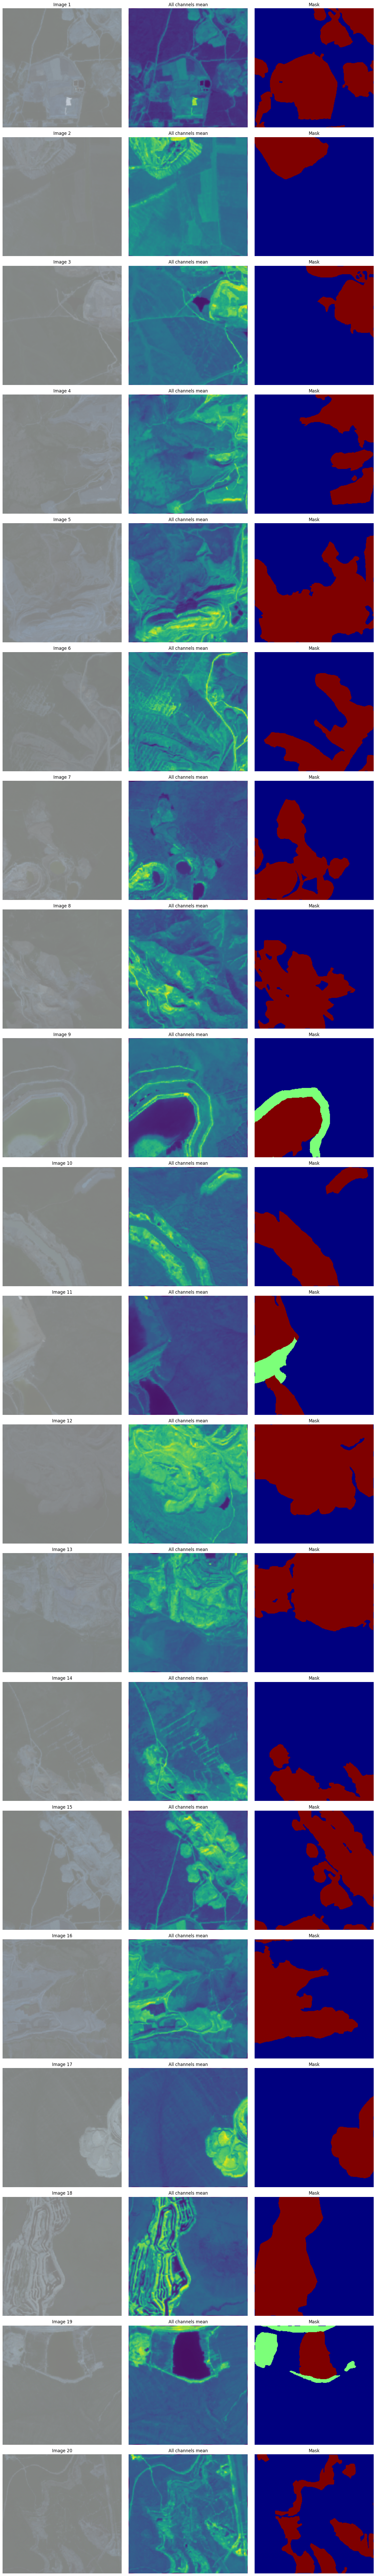

In [ ]:
def visualize_augmentations(dataset, num_samples=20, shift=0):

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        img, mask = dataset[i + shift]

        # Convert tensors to numpy for visualization
        if isinstance(img, torch.Tensor):
            img = img.numpy()
            mask = mask.numpy()

        # Show first 3 channels as RGB (if available)
        rgb_img = img[:3].transpose(1, 2, 0) if img.shape[0] >= 3 else img[0]

        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        # Show all channels mean
        axes[i, 1].imshow(img.mean(axis=0), cmap='viridis')
        axes[i, 1].set_title('All channels mean')
        axes[i, 1].axis('off')

        # Show mask
        axes[i, 2].imshow(mask.argmax(axis=0), cmap='jet')
        axes[i, 2].set_title('Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_augmentations(dataset_train, shift=4)

In [ ]:
def visualize_augmentations(dataset, num_samples=20, shift=0):

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        img, mask = dataset[i + shift]

        # Convert tensors to numpy for visualization
        if isinstance(img, torch.Tensor):
            img = img.numpy()
            mask = mask.numpy()

        # Show first 3 channels as RGB (if available)
        rgb_img = img[:3].transpose(1, 2, 0) if img.shape[0] >= 3 else img[0]

        axes[i, 0].imshow(rgb_img)
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        # Show all channels mean
        axes[i, 1].imshow(img.mean(axis=0), cmap='viridis')
        axes[i, 1].set_title('All channels mean')
        axes[i, 1].axis('off')

        # Show mask
        axes[i, 2].imshow(mask.argmax(axis=0), cmap='jet')
        axes[i, 2].set_title('Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_augmentations(dataset_train, shift=4)

### Создание загрузчиков данных
Функции загрузчиков данных:
- перемешивают данные в датасетах
- разделяют датасеты на батчи

## Создание обучаемой модели

**Модель UNet**

In [ ]:
DEVICE = 'cuda'

model = smp.FPN(
    encoder_name='mit_b5',
    encoder_weights='imagenet',
    in_channels=NUM_CHANNELS,       # Количество каналов изображения
    classes=NUM_CLASSES,            # Количество классов (включая фон)
    decoder_dropout=0.05
)
model.to(DEVICE)

model2 = smp.Unet(
    encoder_name='mit_b5',
    encoder_weights='imagenet',
    in_channels=NUM_CHANNELS,       # Количество каналов изображения
    classes=NUM_CLASSES,            # Количество классов (включая фон)
)
model2.to(DEVICE)

for batch_idx, batch_data in enumerate(dataloader_val):
    if batch_idx == 0:
        t2 = torch.argmax(batch_data[1], dim=1)
        t2 = t2.flatten(start_dim=0)
    else:
        if (batch_idx % 5 == 0):
            print(batch_idx)
        t1 = torch.argmax(batch_data[1], dim=1)
        t1 = t1.flatten(start_dim=0)
        t2 = torch.cat((t2, t1), dim=0)
t2 = t2.cpu().detach().numpy()
_classes = np.unique(t2)
class_weights_ = sklearn.utils.class_weight.compute_class_weight('balanced', classes=_classes, y=t2)
class_weights_ = dict(zip(np.unique(_classes), class_weights_))
print(class_weights_)

clf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1, class_weight=class_weights_)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


5
10
{np.int64(0): np.float64(0.5103623077919374), np.int64(1): np.float64(1.1030726315664252), np.int64(2): np.float64(7.4599566932840355)}


## Создание функции для обучения моделей

**Входные параметры**
- **model** - обучаемая модель
- **num_classes** - количество классов
- **optimizer** - оптимизатор
- **loss_fn** - лосс функция
- **acc_fn** - метрика
- **epochs** - количество эпох
- **data_tr** - обучающий датасет
- **data_val** - валидационный датасет
- **scheduler** - планировщик

**Возвращает историю обучения модели**

In [ ]:
def Trainer(model, model2, num_classes, optimizer, loss_fn, acc_fn, epochs, data_tr, data_val, scheduler=None):
    # История обучения
    history = []
    best_acc = 0
    last_val_loss=10
    last_epoch = 0
    weight = None # torch.tensor([0.1, 0.2, 0.7, 0.0]).to(DEVICE)

    # Цикл эпох
    for epoch in range(epochs):

        # Инициализация переменных для обучения
        lr = None
        if scheduler:
            lr = scheduler.get_last_lr()[0]
        else:
            for param_group in optimizer.param_groups:
                lr = param_group['lr']
        train_loss = 0
        train_acc = 0
        train_accs = [0]*num_classes
        model.train()
        model2.train()

        # Подцикл обучения
        stream = tqdm(data_tr)
        for ind, (X_batch, Y_batch) in enumerate(stream):
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            Y_pred = model.forward(X_batch)
            Y_pred2 = model2.forward(X_batch)
            loss = loss_fn(Y_batch, ((Y_pred + Y_pred2) / 2), weight)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

            train_loss += loss.item() / len(data_tr)
            avg, accs = acc_fn(Y_batch, ((Y_pred + Y_pred2) / 2))
            train_acc += (avg).mean().item()/len(data_tr)
            train_accs = [train_accs[i] + acc/len(data_tr) for i, acc in enumerate(accs.tolist())]
            straccs = ', '.join([f"{acc:.04f}" for acc in train_accs])
            stream.set_description(
                f"Epoch {epoch + 1:{len(str(epochs + 1))}d}. Train. " +
                f"Loss: {train_loss:.04f} | Accs: {straccs} | Avg: {train_acc:.04f} | LR: {lr:.10f}")

        # Инициализация переменных для валидации
        val_loss = 0
        val_acc = 0
        val_accs = [0]*num_classes

        # Подцикл валидации
        model.eval()
        model2.eval()
        stream = tqdm(data_val)
        with torch.set_grad_enabled(False):
            for X_val, Y_val in stream:
                Y_val = Y_val.to(DEVICE)
                X_val = X_val.to(DEVICE)
                Y_hat = model(X_val) # detach and put into cpu
                Y_hat2 = model2(X_val)

                val_loss += loss_fn(Y_val, ((Y_hat + Y_hat2) / 2), weight).mean().item()/len(data_val)
                avg, accs = acc_fn(Y_val, ((Y_hat + Y_hat2) / 2))
                val_acc += (avg).mean().item()/len(data_val)
                val_accs = [val_accs[i] + acc/len(data_val) for i, acc in enumerate(accs.tolist())]
                straccs = ', '.join([f"{acc:.04f}" for acc in val_accs])
                stream.set_description(
                    f"Epoch {epoch + 1:{len(str(epochs + 1))}d}. " +
                    f"Valid. Loss: {val_loss:.04f} | Accs: {straccs} | Avg: {val_acc:.04f} | LR: {lr:.10f}"
                )

        history.append({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_accs": train_accs,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_accs": val_accs,
            "lr": lr,
        })
        if scheduler: scheduler.step()

        last_epoch = epoch + 1

        if best_acc < val_acc:
            torch.save(model.state_dict(), os.path.join(DIR_SAVE, "best_acc_model_weights.pth"))
            torch.save(model2.state_dict(), os.path.join(DIR_SAVE, "best_acc_model2_weights.pth"))
            print('best acc model saved')
            best_acc = val_acc

        if early_stop(last_val_loss, val_loss):
            break
        last_val_loss = val_loss

    return history, last_epoch

def mean_iou(true, pred, num_classes):
    true = torch.argmax(true, dim = 1)
    pred = torch.argmax(torch.softmax(pred, dim = 1), dim = 1)

    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()

    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    EPS = 1e-8
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = torch.nanmean(jaccard[:3])

    return avg_jacc, jaccard[:3]

def cs_loss(y_real, y_pred, weights):
    loss = nn.CrossEntropyLoss(weight=weights)
    return loss(y_pred, torch.argmax(y_real, dim=1))

def early_stop(last_val_loss, new_val_loss, tolerance=0.001):
    difference = abs(last_val_loss) - abs(new_val_loss)
    if difference < tolerance:
        print(f'Early Stop\nDifference: {difference:.6f}\ntolerance: {tolerance}')
        return True
    return False

def stats_plot(last_epoch):
    train_losses = [x["train_loss"] for x in history]
    val_losses = [x["val_loss"] for x in history]
    train_metrics = [x["train_acc"] for x in history]
    val_metrics = [x["val_acc"] for x in history]
    lr_metrics = [x["lr"] for x in history]

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].plot(range(last_epoch), train_losses, label="train")
    ax[0].plot(range(last_epoch), val_losses, label="val")
    ax[0].legend(loc='best')
    ax[0].set_title("Loss")
    ax[1].plot(range(last_epoch), train_metrics, label="train")
    ax[1].plot(range(last_epoch), val_metrics, label="val")
    ax[1].legend(loc='best')
    ax[1].set_title("Acc")
    ax[2].plot(range(last_epoch), lr_metrics, label="learning rate")
    ax[2].legend(loc='best')
    ax[2].set_title("LR")
    plt.show()

def train_RFC(RFC, model, model2):
  model.eval()
  model2.eval()
  stream = tqdm(dataloader_val)
  with torch.set_grad_enabled(False):
      for ind, (X_batch, Y_batch) in enumerate(stream):
          Y_batch = Y_batch.to(DEVICE)
          X_batch = X_batch.to(DEVICE)
          Y_pr1 = model(X_batch)
          Y_pr2 = model2(X_batch)
          if ind == 0:
              st = torch.argmax(Y_batch, dim=1)
              st = st.flatten(start_dim=0)
              Y_pr1 = torch.argmax(torch.softmax(Y_pr1, dim = 1), dim = 1).unsqueeze(1)
              Y_pr2 = torch.argmax(torch.softmax(Y_pr2, dim = 1), dim = 1).unsqueeze(1)
              st_addon = torch.cat((Y_pr1, Y_pr2), dim=1)
              st_pred = torch.cat((X_batch, st_addon), dim=1).flatten(start_dim=2)
          else:
              st_it = torch.argmax(Y_batch, dim=1)
              st_it = st_it.flatten(start_dim=0)
              st = torch.cat((st, st_it), dim=0)
              Y_pr1 = torch.argmax(torch.softmax(Y_pr1, dim = 1), dim = 1).unsqueeze(1)
              Y_pr2 = torch.argmax(torch.softmax(Y_pr2, dim = 1), dim = 1).unsqueeze(1)
              st_addon = torch.cat((Y_pr1, Y_pr2), dim=1)
              Y_pred_both = torch.cat((X_batch, st_addon), dim=1).flatten(start_dim=2)
              st_pred = torch.cat((st_pred, Y_pred_both), dim=0)
      st = st.cpu().detach().numpy()
      st_pred = torch.transpose(st_pred, 0, 1).flatten(start_dim=1).cpu().detach().numpy().transpose()

  RFC = RFC.fit(st_pred, st)

  return RFC

## Обучение модели

### Обучение модели и сохранение результатов

Epoch  1. Train. Loss: 0.4717 | Accs: 0.7919, 0.5984, 0.2234 | Avg: 0.5379 | LR: 0.0001000000: 100%|██████████| 57/57 [02:15<00:00,  2.37s/it]
Epoch  1. Valid. Loss: 0.3352 | Accs: 0.8027, 0.7202, 0.5332 | Avg: 0.6854 | LR: 0.0001000000: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]


best acc model saved


Epoch  2. Train. Loss: 0.1910 | Accs: 0.9034, 0.7938, 0.5836 | Avg: 0.7603 | LR: 0.0000800000: 100%|██████████| 57/57 [02:09<00:00,  2.27s/it]
Epoch  2. Valid. Loss: 0.2327 | Accs: 0.8903, 0.7332, 0.6540 | Avg: 0.7591 | LR: 0.0000800000: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


best acc model saved


Epoch  3. Train. Loss: 0.1464 | Accs: 0.9229, 0.8295, 0.6718 | Avg: 0.8081 | LR: 0.0000640000: 100%|██████████| 57/57 [02:10<00:00,  2.28s/it]
Epoch  3. Valid. Loss: 0.1568 | Accs: 0.8864, 0.8232, 0.6546 | Avg: 0.7881 | LR: 0.0000640000: 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]


best acc model saved


Epoch  4. Train. Loss: 0.1269 | Accs: 0.9324, 0.8486, 0.7344 | Avg: 0.8385 | LR: 0.0000512000: 100%|██████████| 57/57 [02:11<00:00,  2.30s/it]
Epoch  4. Valid. Loss: 0.1667 | Accs: 0.9130, 0.8242, 0.6691 | Avg: 0.8021 | LR: 0.0000512000: 100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


best acc model saved
Early Stop
Difference: -0.009863
tolerance: 0.001


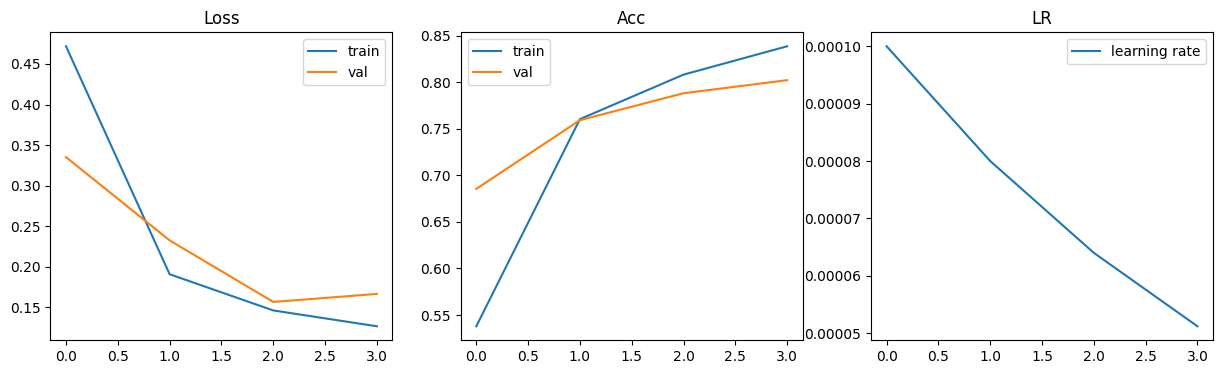

In [ ]:
LR = 0.0001                                                                #параметр скорости обучения
NUM_EPOCHS = 20                                                           #кол-во эпох
FN_LOSS = cs_loss                                                          #ф-ция ошибки
FN_ACC = functools.partial(mean_iou, num_classes=NUM_CLASSES)

# Здесь указать папку, куда сохранять веса модели и показатели обучения
DIR_SAVE = r""

opt = torch.optim.AdamW(model.parameters(), lr=LR)                           #оптимизатор
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

history, last_epoch = Trainer(
    model=model,
    model2=model2,
    optimizer=opt,
    loss_fn=FN_LOSS,
    acc_fn=FN_ACC,
    data_tr=dataloader_train,
    data_val=dataloader_val,
    num_classes=NUM_CLASSES,
    epochs=NUM_EPOCHS,
    scheduler=sch
    )

# Сохранение весов модели
torch.save(model.state_dict(), os.path.join(DIR_SAVE, "model_weights.pth"))
torch.save(model2.state_dict(), os.path.join(DIR_SAVE, "model2_weights.pth"))

# Сохранение истории обучения
with open(os.path.join(DIR_SAVE, "history.json"), "w") as f:
    json.dump(history, f, indent=4)

stats_plot(last_epoch)

clf = train_RFC(clf, model, model2)

## Построение графиков обучения

## Инференс

**Функция принимает следующие параметры:**
- **data_val** - валидационный датасет
- **model** - обученная модель
- **N** - количество предсказаний модели

(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)
(65536,)
(256, 256)


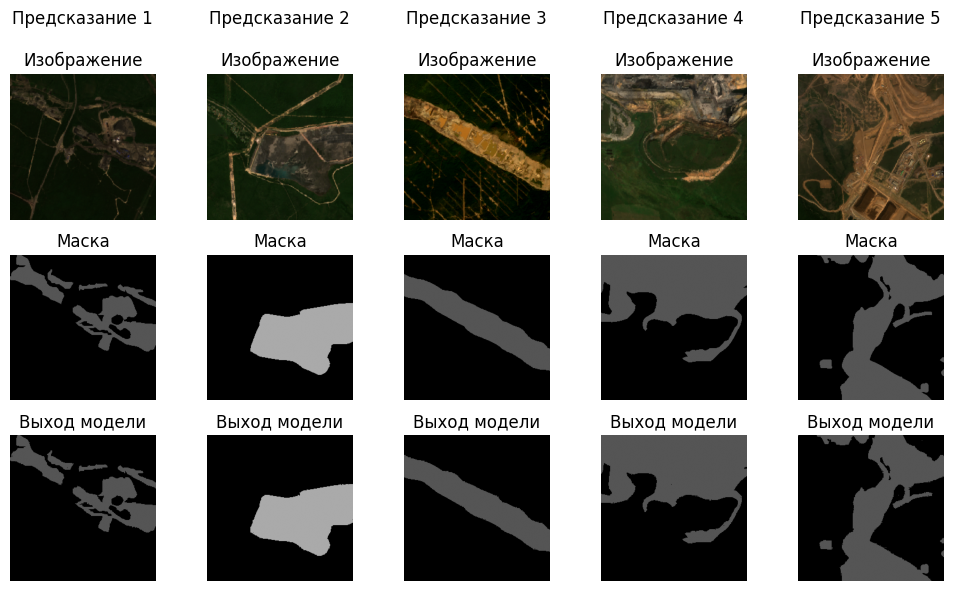

In [ ]:
def inference(data_val, model, model2, N):                                               #функция визуалиции для валид
    data_val = DataLoader(data_val, batch_size=1, shuffle=True, pin_memory=True)
    model.eval()
    model2.eval()
    fig, ax = plt.subplots(3, N, figsize=(N*2, 3*2))
    for i, (x, y) in list(enumerate(data_val))[:N]:
        img = x.squeeze().detach().numpy()
        msk = y.squeeze().detach().numpy()
        x = x.to(DEVICE)
        with torch.set_grad_enabled(False):
            Y_pr1 = model(x)
            Y_pr2 = model2(x)
            Y_pr1 = torch.argmax(torch.softmax(Y_pr1, dim = 1), dim = 1)
            Y_pr2 = torch.argmax(torch.softmax(Y_pr2, dim = 1), dim = 1)
            st_addon = torch.cat((Y_pr1, Y_pr2), dim=0)
            st_pred = torch.cat((x.squeeze(0), st_addon), dim=0).flatten(start_dim=1)
            st_pred = st_pred.cpu().detach().numpy().transpose()

        y_ = clf.predict(st_pred)
        y_ = y_.reshape((256, 256))
        rgb = img[[2, 1, 0]].transpose(1, 2, 0)
        rgb = np.interp(rgb, [rgb.min(), rgb.max()], [0, 1])
        fmsk = np.zeros_like(msk[0])
        for j in range(1, msk.shape[0]):
            fmsk[msk[j] != 0] = j
        ax[0][i].imshow(rgb)
        ax[0][i].axis("off")
        ax[0][i].set_title(f"Предсказание {i + 1}\n\nИзображение")
        ax[1][i].imshow(fmsk, cmap='gray', vmin=0, vmax=3)
        ax[1][i].axis("off")
        ax[1][i].set_title("Маска")
        ax[2][i].imshow(y_, cmap='gray', vmin=0, vmax=3)
        ax[2][i].axis("off")
        ax[2][i].set_title("Выход модели")
    plt.tight_layout()
    plt.show()

inference(dataset_val, model, model2, 5)

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))
model2.load_state_dict(torch.load('model2_weights.pth'))
import joblib

clf = joblib.load("model.pkl")

In [ ]:
model.load_state_dict(torch.load('best_acc_model_weights.pth'))
model2.load_state_dict(torch.load('best_acc_model2_weights.pth'))
import joblib

clf = joblib.load("model.pkl")

In [ ]:
torch.save(model.state_dict(), os.path.join(DIR_SAVE, "model_weights.pth"))
torch.save(model2.state_dict(), os.path.join(DIR_SAVE, "model2_weights.pth"))
import joblib

joblib.dump(clf, "model.pkl")

## Сохранение результатов предсказаний

In [ ]:
# Здесь указать папку, куда сохранения маски
DIR_OUT = r"segmentation_openset"
os.makedirs(DIR_OUT, exist_ok=True)  # Create output directory
dataset_val_out = Dataset(
    LST_TEST_IMG,
    LST_VAL_MASK,
    NUM_CLASSES,
    LST_CHANNELS,
    return_paths=True,
    transform=get_val_transform(NUM_CHANNELS)
)

model.eval()
model2.eval()
for i, (x, pth_img) in list(enumerate(dataset_val_out)):
    img = x.squeeze().detach().numpy()
    x = x.unsqueeze(dim=0)
    x = x.to(DEVICE)
    with torch.set_grad_enabled(False):
        Y_pr1 = model(x)
        Y_pr2 = model2(x)
        Y_pr1 = torch.argmax(torch.softmax(Y_pr1, dim = 1), dim = 1)
        Y_pr2 = torch.argmax(torch.softmax(Y_pr2, dim = 1), dim = 1)
        st_addon = torch.cat((Y_pr1, Y_pr2), dim=0)
        st_pred = torch.cat((x.squeeze(0), st_addon), dim=0).flatten(start_dim=1)
        st_pred = st_pred.cpu().detach().numpy().transpose()

        y_ = clf.predict(st_pred)
        y_ = y_.reshape((256, 256))
    with rasterio.open(pth_img) as src:
        meta = src.meta.copy()
        meta.update(count=1, dtype='uint8')  # Masks are single-band
    with rasterio.open(os.path.join(DIR_OUT, rf"{os.path.basename(pth_img)}"), "w", **meta) as f:
        f.write_band(1, y_)

!7z a -tzip segmentation_openset.zip segmentation_openset

In [ ]:
# Здесь указать папку, куда сохранения маски
DIR_OUT = r"segmentation_closedset"
os.makedirs(DIR_OUT, exist_ok=True)  # Create output directory
dataset_val_out = Dataset(
    LST_FINAL_TEST_IMG,
    LST_VAL_MASK,
    NUM_CLASSES,
    LST_CHANNELS,
    return_paths=True,
    transform=get_val_transform(NUM_CHANNELS)
)

model.eval()
model2.eval()
for i, (x, pth_img) in list(enumerate(dataset_val_out)):
    img = x.squeeze().detach().numpy()
    x = x.unsqueeze(dim=0)
    x = x.to(DEVICE)
    with torch.set_grad_enabled(False):
        Y_pr1 = model(x)
        Y_pr2 = model2(x)
        Y_pr1 = torch.argmax(torch.softmax(Y_pr1, dim = 1), dim = 1)
        Y_pr2 = torch.argmax(torch.softmax(Y_pr2, dim = 1), dim = 1)
        st_addon = torch.cat((Y_pr1, Y_pr2), dim=0)
        st_pred = torch.cat((x.squeeze(0), st_addon), dim=0).flatten(start_dim=1)
        st_pred = st_pred.cpu().detach().numpy().transpose()

        y_ = clf.predict(st_pred)
        y_ = y_.reshape((256, 256))
    with rasterio.open(pth_img) as src:
        meta = src.meta.copy()
        meta.update(count=1, dtype='uint8')  # Masks are single-band
    with rasterio.open(os.path.join(DIR_OUT, rf"{os.path.basename(pth_img)}"), "w", **meta) as f:
        f.write_band(1, y_)



!7z a -tzip segmentation_closedset.zip segmentation_closedset

In [ ]:
!cp /content/model_weights.pth /content/drive/MyDrive/ScienceDataLab/
!cp /content/model2_weights.pth /content/drive/MyDrive/ScienceDataLab/
!cp /content/model.pkl /content/drive/MyDrive/ScienceDataLab/